# Setup

## Imports

In [ ]:
# If loading new data
DATABASE_URL = "2.tcp.ngrok.io:14800"
DATA_FILE = "all"
DATA_FOLDER = '/content/drive/MyDrive/debateData/'
DATA_PATH =  DATA_FOLDER + DATA_FILE

In [ ]:
if DATA_FOLDER.startswith("/content/drive/MyDrive/"):
  from google.colab import drive
  from os import mkdir
  from pathlib import Path

  drive.mount('/content/drive', force_remount=True)
  Path(DATA_FOLDER).mkdir(exist_ok=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine, table, column, select, text
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import sparse
import itertools

db = create_engine(f"postgresql://postgres:password@{DATABASE_URL}/debate-cards")
pd.set_option('display.float_format', '{:.3f}'.format)
%matplotlib inline

## Data

In [ ]:
try:
  buckets = pd.read_feather(DATA_PATH + '_counts.feather')
except FileNotFoundError:
  query = 'SELECT * FROM "EvidenceBucket";'
  buckets = pd.read_sql(query, db)
  buckets.to_feather(DATA_PATH + '_counts.feather')
buckets = buckets.set_index('id')

In [ ]:
try:
  all = pd.read_feather(DATA_PATH + '.feather')
except FileNotFoundError:
  query = """
    SELECT id, "fileId", pocket, hat, block, tag, fullcite, cite, "bucketId" FROM "Evidence"
  """
  all = pd.read_sql(query, db)
  print("Data loaded")
  all.to_feather(DATA_PATH + '.feather')
all = all.set_index('id')
evidence = all

In [ ]:
def loadTagIds(tag: str):
  try:
    ids = pd.read_feather(DATA_PATH + f'_{tag}Ids.feather')
  except FileNotFoundError:
    query = f"""
      SELECT evidence.id
      FROM "Evidence" evidence
        INNER JOIN "_FileToTag" ftt ON evidence."fileId" = ftt."A"
        INNER JOIN "Tag" tag on ftt."B" = tag.id
      WHERE tag.name='{tag}'
    """
    ids = pd.read_sql(query, db)
    print(f"{len(ids)} {tag} loaded")
    ids.to_feather(DATA_PATH + f'_{tag}Ids.feather')
  return ids

In [ ]:
try:
  nonAnalyticIds = pd.read_feather(DATA_PATH + '_nonAnalyticIds.feather')
except FileNotFoundError:
  query = """SELECT evidence.id FROM "Evidence" evidence WHERE fulltext != ''"""
  nonAnalyticIds = pd.read_sql(query, db)
  print("Data loaded")
  nonAnalyticIds.to_feather(DATA_PATH + '_nonAnalyticIds.feather')
nonAnalytic = all.loc[nonAnalyticIds.id]

In [ ]:
openevIds = loadTagIds("openev")
openev = all.loc[openevIds.id]

In [ ]:
ids21 = loadTagIds("2021")

In [ ]:
from functools import reduce
openev2021 = all.loc[reduce(np.intersect1d, [openevIds.id, ids21.id, nonAnalyticIds.id])]
len(openev2021)

29804

In [ ]:
from IPython.display import HTML
parentStyles = """
  margin: 50px;
  height: 500px;
  display: flex;
  overflow-x: scroll;
"""
childStyles = """"
  padding: 10px;
  flex-shrink: 0;
  flex-basis: 400px;
  overflow: scroll;
"""

def showCards(cards: pd.DataFrame, showIds = False, fileName=None):
    markups = pd.read_sql(f"""SELECT id, markup FROM "Evidence" WHERE id IN ({",".join(cards.index.map(str))});""", db)
    markups = markups.sort_values(by='id',  key=lambda ids: [cards.index.get_loc(id) for id in ids]).markup
    headers = [f"<h2>{id}</h2>" if showIds else "" for id in cards.index]
    divs = "\n".join(
        [f"<div style='{childStyles}'>{headers[i]}{markup}</div>" for i, markup in enumerate(markups)])
    html = HTML(f"<div style='{parentStyles}'>{divs}</div>")
    if fileName is None:
      return html

    path = DATA_PATH + fileName + '.html'
    with open(path, 'w') as f:
      f.write(str(html.data))
    return HTML(f"<a href={path}>Open</a>")

def showCard(i: int):
  return HTML(f"<div style='{childStyles}'>{all.loc[i].markup}</div>")
def showBucket(id: int, count: int=None):
  return showCards(all[all.bucketId == id].iloc[0:count])
def showBucketSeries(series, indexes=range(5), iloc=0):
  return showCards(all.loc[[all[all.bucketId == series.iloc[i]].index[iloc] for i in indexes]], showIds=True)
  # showCards([all[all.bucketId == buckets[series.index[i]]].iloc[iloc] for i in indexes])

# Analysis

## Misc

In [ ]:
evidence = all.loc[np.intersect1d(openevIds.id, nonAnalyticIds.id)]

In [ ]:
evidence = all

In [ ]:
levels = ['fileId', 'pocket', 'hat', 'block']

In [ ]:
def describeSiblings(groups, repeat=True):
  sizes = groups.size()
  return (sizes.repeat(sizes) if repeat else sizes).describe()

In [ ]:
def calcSizes(repeat=True):
    levelSizes = pd.DataFrame({
        level: describeSiblings(evidence.groupby(levels[0:i+1]), repeat) for (i, level) in enumerate(levels)
    })
    levelSizes['bucket'] = describeSiblings(evidence.groupby('bucketId'), repeat)
    return levelSizes

In [ ]:
calcSizes(True)

In [ ]:
calcSizes(False)

In [ ]:
def plotGroupSizes(grouping):
  groupSizes = evidence.groupby(grouping).size().value_counts().sort_index()
  return plt.plot(groupSizes.index, groupSizes * groupSizes.index, label=grouping[-1])

In [ ]:
plotGroupSizes(['fileId'])
plotGroupSizes(['fileId', 'pocket'])
plotGroupSizes(['fileId', 'pocket', 'hat'])
plt.legend()
plt.xlim(0, 150)

In [ ]:
plotGroupSizes(['bucketId'])
plt.xlim(1, 300)
plt.yscale('log')

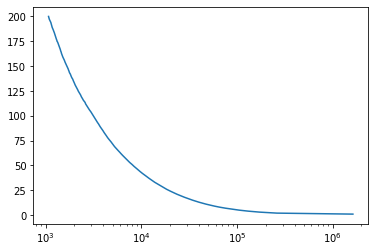

In [ ]:
counts = evidence.groupby("bucketId").size().value_counts().sort_index(ascending=False)
cumCounts = pd.DataFrame({
    "samples": (counts * counts.index).cumsum(),
    "vocab": counts.cumsum()
})
plotCounts = cumCounts.vocab.loc[200:0]
plt.plot(plotCounts, plotCounts.index)
plt.xscale('log')

In [ ]:
cumCounts.loc[[5, 10, 20, 50, 100, 200]]

,samples,vocab
5,2288196,105453
10,1945572,52594
20,1575268,25027
50,1071959,8196
100,729696,3154
200,449578,1071


In [ ]:
1945572 / 52594

In [ ]:
bucketSizes = evidence.groupby('bucketId').size().sort_values(ascending=False)
plt.plot(np.arange(100), bucketSizes.iloc[0:100])

In [ ]:
def plotHeaderSizes(header: str):
  counts = evidence[header].str.len().value_counts()
  sizes = (counts / sum(counts)).sort_index().plot(label=header, xlim=(0, 30))
[plotHeaderSizes(h) for h in ['block', 'hat',]]

## Graph

### Adjacency

In [ ]:
evidence = all

In [ ]:
buckets = evidence['bucketId'].drop_duplicates().reset_index(drop=True)
bucketIndexes = pd.Series(buckets.index.values, index=buckets)
fileIds = evidence['fileId'].drop_duplicates().reset_index(drop=True)

In [ ]:
import itertools
from scipy import sparse
from sklearn.preprocessing import normalize

In [ ]:
def genEdges():
  edges = {}
  print("Grouping...")
  groups = evidence.groupby(['fileId', 'pocket', 'hat', 'block'])
  print("Generating edges...")
  for name, group in tqdm(groups):
    for edge in itertools.combinations(bucketIndexes[group['bucketId']], 2):
      edges[edge] = edges.get(edge, 0) + 1
  return edges

In [ ]:
try:
  adjacency = sparse.load_npz(DATA_PATH + '.npz')
except FileNotFoundError:
  edges = genEdges()
  keys = np.array(list(edges.keys()))
  adjacency = sparse.coo_matrix((list(edges.values()), (keys[:, 0], keys[:, 1])), shape=(len(buckets), len(buckets)), dtype=np.int32)

  # Evidence should be a few times more related to itself than any other evidence, 3 specifically is arbitrary and could be changed
  diag = adjacency.max(axis=0).A[0] * 3
  # Fix evidence thats not related to anything
  diag[diag == 0] = 1
  adjacency.setdiag(diag)

  sparse.save_npz(DATA_PATH + '.npz', adjacency)
adjacency = adjacency.tocsc()
adjacencyN = normalize(adjacency, norm='l1', axis=0)
adjacencyN

<1631614x1631614 sparse matrix of type '<class 'numpy.float64'>'
	with 5502944 stored elements in Compressed Sparse Column format>

In [ ]:
# squaredN = adjacencyN ** 2

In [ ]:
def listToVec(l, size):
  return sparse.csc_matrix(
      (np.ones(len(l)), (l, np.zeros(len(l), dtype=np.int32))),
      shape=(size, 1)
  )

def vecToSortedSeries(v):
  return pd.Series(index=v.tocoo().row, data=v.data).sort_values(ascending=False)

def getAdjacent(ids, iters=2, raw=False):
  v = listToVec(list(ids), adjacencyN.shape[0])
  if (iters % 2 == 1): v = adjacencyN @ v
  for i in range(iters // 2): v = squaredN @ v

  return v if raw else vecToSortedSeries(v)

### Install

In [ ]:
# https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb
!echo "deb http://downloads.skewed.de/apt focal main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

In [ ]:
import graph_tool.all as gt

### Generate

In [ ]:
def adjacencyToGt(adjacency):
  g = gt.Graph()
  g.add_vertex(adjacency.shape[0])

  ids = adjacency.nonzero()
  weights = adjacency[ids]

  g.edge_properties.weight = g.new_edge_property('double')
  g.edge_properties.inverse_weight = g.new_edge_property('double')
  g.add_edge_list(np.transpose(ids))
  g.ep.weight.a = weights
  g.ep.inverse_weight.a = 1 - weights
  return g

In [ ]:
evidenceGraph = adjacencyToGt(adjacencyN)
graph = evidenceGraph

In [ ]:
bucketIndexes[28377]

29737

In [ ]:
def showPath(vlist, iloc=0):
  return showBucketSeries(buckets.iloc[[int(v) for v in vlist]], indexes=range(len(vlist)), iloc=iloc)

In [ ]:
vlist, elist = gt.shortest_path(graph, bucketIndexes[5453], bucketIndexes[8998], weights=graph.ep.inverse_weight)
[str(v) for v in vlist], [str(e) for e in elist]

(['317887', '340360', '462', '221631'],
 ['(317887, 340360)', '(340360, 462)', '(462, 221631)'])

In [ ]:
showPath(vlist)

## Embedding

In [ ]:
threshold = 10
suffix = "common" + str(threshold)

In [ ]:
commonIds = all.value_counts("bucketId")
commonIds = commonIds[commonIds >= threshold].index

In [ ]:
evidence = nonAnalytic[nonAnalytic.bucketId.isin(commonIds)]
# evidence = openev2021

### Build PPMI Matrix

In [ ]:
buckets = evidence['bucketId'].drop_duplicates().reset_index(drop=True)
bucketIndexes = pd.Series(buckets.index.values, index=buckets)
fileIds = evidence['fileId'].drop_duplicates().reset_index(drop=True)

In [ ]:
from scipy import sparse
import itertools

levels = ['fileId', 'pocket', 'hat', 'block']
def build_co_occurrence(window_level="pocket"):
  M = sparse.lil_matrix((len(buckets), len(buckets)), dtype=np.int32)

  groups = evidence.groupby(levels[0:levels.index(window_level) + 1])
  for name, group in tqdm(groups):
    # Sparse matricies cant really vecotrize this
    for edge in itertools.combinations(bucketIndexes[group['bucketId']], 2):
      M[edge] += 1
  return (M + M.T).tocsr()

In [ ]:
try:
  co_occurence = sparse.load_npz(f'{DATA_PATH}_cooc_{suffix}.npz').tocsr()
except FileNotFoundError:
  co_occurence = build_co_occurrence()
  sparse.save_npz(f'{DATA_PATH}_cooc_{suffix}.npz', co_occurence)
co_occurence

<52594x52594 sparse matrix of type '<class 'numpy.int32'>'
	with 8978634 stored elements in Compressed Sparse Row format>

In [ ]:
def total_to_divideMatrix(totals: np.array):
  with np.errstate(divide='ignore'):
    M = 1 / totals
  M[np.isinf(M)] = 0
  return sparse.diags(M)

def build_ppmi(M: sparse.csr_matrix):
  probabilities = M.copy()

  # Will be same when symmetric
  word_totals = np.array(co_occurence.sum(axis=0))[0]
  context_totals = np.array(co_occurence.sum(axis=1))[:, 0]

  # pmi_wc = log(P(w, c) / (P(w) * P(c)))
  #        = log((#(w, c) / total) / ((#(w) / total) * (#(c) / total)))
  #        = log(#(w, c) * total) / (#(w) * #(c))

  #(w, c) * total
  probabilities *= word_totals.sum()

  word_divider = total_to_divideMatrix(word_totals)
  context_divider = total_to_divideMatrix(context_totals)
  # / ((#w) * (#c))
  probabilities = word_divider @ probabilities @ context_divider # Divide each row by word_divider, column by context_divider

  probabilities.data = np.maximum(probabilities.data, 1) # Clamps log to 0 for ppmi
  probabilities.data = np.log2(probabilities.data)
  return probabilities

In [ ]:
ppmi = build_ppmi(co_occurence)
# print("Saving")
# sparse.save_npz(f'{DATA_PATH}_ppmi_{suffix}.npz', ppmi)
# bucketIndexes.to_csv(f'{DATA_PATH}_bucketIndexes_{suffix}.csv')
ppmi

<52594x52594 sparse matrix of type '<class 'numpy.float64'>'
	with 8978634 stored elements in Compressed Sparse Row format>

In [ ]:
# plt.matshow(ppmi[0:5000, 0:5000].todense())

### Truncated SVD Factorization

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
def reduce_to_k_dim(ppmi: sparse.csc_matrix, k: int, eig=0, n_iters=10):
  print(f"Reducing {ppmi.shape[0]} cards to {k} dimensions")
  global svd
  svd = TruncatedSVD(n_components=k, n_iter=n_iters)
  embeddings = svd.fit_transform(ppmi)
  # https://aclanthology.org/Q15-1016.pdf shows not scaling by singular values can give better results
  embeddings /= (svd.singular_values_ ** (1 - eig))
  return normalize(embeddings)

In [ ]:
embeddings = reduce_to_k_dim(ppmi, 100)

Reducing 52594 cards to 1000 dimensions


In [ ]:
np.save(f'{DATA_PATH}_embed_{suffix}.npy', embeddings)

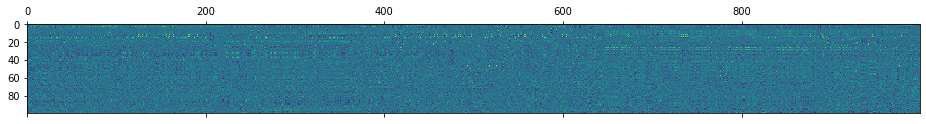

In [ ]:
plt.matshow(embeddings.T[:, 0:1000])

### Analysis

In [ ]:
embeddings2d = reduce_to_k_dim(ppmi, 2, n_iters=20, eig=1)

Reducing 52594 cards to 2 dimensions


In [ ]:
from sklearn.manifold import TSNE

In [ ]:
embeddings50 = reduce_to_k_dim(ppmi, 50, eig=1)
print("Embeddings done")
tsne = TSNE(n_components=2)
tsneData = tsne.fit_transform(embeddings50, )

Reducing 52594 cards to 50 dimensions
Embeddings done


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
def plot_cards(coords, cards, freq=1000):
  num_colors = 100
  cm = plt.get_cmap('gist_rainbow')
  for i, card in cards.iterrows():
    x, y = coords[bucketIndexes[card.bucketId]]
    if i % freq == 0: plt.scatter(x, y, color=cm(((card.fileId * 149) % num_colors) / num_colors))

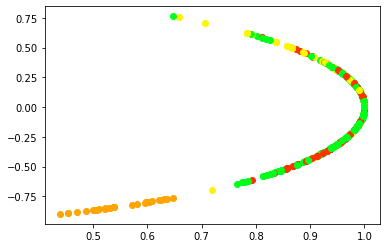

In [ ]:
# plot_cards(embeddings2d, evidence.drop_duplicates('bucketId'), 1000)
plot_cards(embeddings2d, evidence[evidence.fileId.isin([1958, 1143, 1729, 2235])], 2)

In [ ]:
evidence.drop_duplicates('bucketId').value_counts('fileId')

fileId
1958      50
1143      31
1729      29
1726      26
2335      26
          ..
47055      1
47051      1
47038      1
47037      1
139125     1
Length: 34518, dtype: int64

### Graph

#### Build

In [ ]:
# !pip install faiss-cpu
# import faiss

In [ ]:
try:
  embeddings
except:
  embeddings = np.load(f'{DATA_PATH}_embed_{suffix}.npy')

In [ ]:
def buildGraph(embeddings, limit=20, cutoff=0.6, batch_size=2048):
  batches = list(range(0, embeddings.shape[0], batch_size)) + [embeddings.shape[0]]
  g = sparse.lil_matrix((embeddings.shape[0], embeddings.shape[0]))

  for start, end in tqdm(zip(batches, batches[1:]), total=len(batches) - 1):
    similarities = embeddings[start:end] @ embeddings.T
    # Set similarities with self to 0
    similarities[np.arange(end - start), np.arange(end - start) + start] = 0

    # Flip signs so sort is in correct direction
    similarities *= -1
    argMaxes = similarities.argpartition(10)[:, :limit]
    similarities *= -1

    # Get values above cuttoff
    max_values = similarities[np.arange(argMaxes.shape[0])[:, np.newaxis], argMaxes]
    cutoff_indexes = (max_values >= cutoff).nonzero()
    top_indexes = cutoff_indexes[0], argMaxes[cutoff_indexes]

    g[top_indexes[0] + start, top_indexes[1]] = similarities[top_indexes]
  return g

In [ ]:
adjacency = buildGraph(embeddings, limit=20, cutoff=0.6, batch_size=2048)

  0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.matshow(adjacency[:1000, :1000].todense())

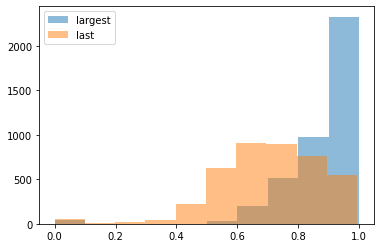

In [ ]:
# plt.hist(top[:, 0], alpha=0.5, label='largest')
# plt.hist(top[:, -1], alpha=0.5, label='last')
# plt.legend()

In [ ]:
import networkx as nx

In [ ]:
g = nx.Graph(adjacency)

In [ ]:
nx.write_gml(g, f'{DATA_PATH}_graph_{suffix}.gml')

#### Analyze

In [ ]:
g[0]

AtlasView({124: {'weight': 0.9172831237736033}, 604: {'weight': 0.9401104840595443}, 1573: {'weight': 0.9174791112235398}, 3370: {'weight': 0.9184135340064117}, 4902: {'weight': 0.9394870981094164}, 5733: {'weight': 0.9146740962478954}, 6026: {'weight': 0.9198903465102997}, 8012: {'weight': 0.9186000148331361}, 9545: {'weight': 0.9485246700147486}, 11550: {'weight': 0.9194888718930746}, 12128: {'weight': 0.9418304351590978}, 23920: {'weight': 0.937084838295559}, 24534: {'weight': 0.9231894091579408}, 24735: {'weight': 0.9113847785548308}, 33649: {'weight': 0.9153059006371017}, 39101: {'weight': 0.9361293497842377}, 43760: {'weight': 0.9225095892410087}, 45083: {'weight': 0.9240783733411733}, 46660: {'weight': 0.9124260886479462}, 46965: {'weight': 0.9385682991191093}, 156: {'weight': 0.8466351376686468}, 1725: {'weight': 0.7641649072295739}, 4297: {'weight': 0.9058916918514144}, 5089: {'weight': 0.8192997483621121}, 6838: {'weight': 0.8325341870453165}, 10237: {'weight': 0.801893286430

## Semantic index

### Install

In [ ]:
%pip install txtai[graph]

In [ ]:
%pip install sentence-transformers

### Index

In [ ]:
from sentence_transformers import SentenceTransformer
from txtai.embeddings import Embeddings

In [ ]:
embeddings = Embeddings({
  "path": "sentence-transformers/all-mpnet-base-v2",
  "content": True,
  "functions": [
    {"name": "graph", "function": "graph.attribute"},
  ],
  "expressions": [
      {"name": "topic", "expression": "graph(indexid, 'topic')"},
      {"name": "topicrank", "expression": "graph(indexid, 'topicrank')"}
  ],
  "graph": {
      "limit": 100,
      "minscore": 0.10,
      "topics": {
          "terms": 4,
          "resolution" : 100
      }
  }
})

In [ ]:
bucketCards = evidence.drop_duplicates("bucketId")

In [ ]:
docIterator = ((card.bucketId, card.tag, None) for _, card in bucketCards.iterrows())

In [ ]:
embeddings.index(tqdm(docIterator, total=len(bucketCards)))

  0%|          | 0/52594 [00:00<?, ?it/s]

In [ ]:
embeddings.save(DATA_PATH + "_commonBuckets_mpnet.tar.gz")

In [ ]:
print(embeddings.graph.backend.number_of_nodes(), embeddings.graph.backend.number_of_edges())
embeddings.graph.backend.number_of_edges() / embeddings.graph.backend.number_of_nodes()

52594 379619


7.217914591017987

In [ ]:
def david_distance(source, target, attrs):
    distance = max(1.0 - attrs["weight"], 0.0)
    return distance if distance >= 0.15 else 1.00

def david_showpath(source, target, the_graph):
    return nx.shortest_path(the_graph, source, target, david_distance)

## Profiler

In [ ]:
!pip install line_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 673.6/673.6 KB 41.4 MB/s eta 0:00:00


In [ ]:
%load_ext line_profiler